In [ ]:
!pip install open3d


In [ ]:
import open3d as o3d

# Load the 3D model
mesh = o3d.io.read_triangle_mesh("5nlt_surface.stl")

# Preprocess the 3D model
mesh = mesh.remove_duplicated_vertices()
mesh = mesh.remove_degenerate_triangles()
mesh = mesh.remove_unreferenced_vertices()

# Calculate the surface area
surface_area = mesh.get_surface_area()

# Calculate the volume
volume = mesh.get_volume()

# Calculate the normals
mesh.compute_vertex_normals()
normals = mesh.vertex_normals

# Print the calculated features
print("Surface area:", surface_area)
print("Volume:", volume)
print("Normals:", normals)

Surface area: 8245.288268678489
Volume: 27541.16617044212
Normals: std::vector<Eigen::Vector3d> with 11567 elements.
Use numpy.asarray() to access data.


In [ ]:
!wget https://raw.githubusercontent.com/Acellera/moleculekit/master/extra_requirements.txt


--2023-03-08 07:57:39--  https://raw.githubusercontent.com/Acellera/moleculekit/master/extra_requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119 [text/plain]
Saving to: ‘extra_requirements.txt’

extra_requirements. 100%[===================>]     119  --.-KB/s    in 0s      

2023-03-08 07:57:39 (2.94 MB/s) - ‘extra_requirements.txt’ saved [119/119]



In [ ]:
#not working


from moleculekit.molecule import Molecule

# Load the PDB file into a Molecule object
pdb_file = '5nlt.pdb'
mol = Molecule(pdb_file)

# Save the molecule as an STL file
stl_file = '5nlt.stl'
mol.write(stl_file, type='stl')


Surface area: 8245.288268678489
Volume: 27541.16617044212
Normals: std::vector<Eigen::Vector3d> with 11567 elements.
Use numpy.asarray() to access data.



In [ ]:
!pip install simtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install openmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#radius of gyration

from simtk import unit
from simtk.openmm.app import PDBFile
from simtk.openmm import app, LangevinIntegrator, Platform, Simulation

# Load the PDB file
pdb = PDBFile('5nlt.pdb')

# Create the OpenMM system
forcefield = app.ForceField('amber99sb.xml', 'tip3p.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.PME,
                                 nonbondedCutoff=1.0*unit.nanometers)
integrator = LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds,
                                2.0*unit.femtoseconds)
simulation = Simulation(pdb.topology, system, integrator,
                        Platform.getPlatformByName('CUDA'))
simulation.context.setPositions(pdb.positions)

# Calculate the radius of gyration
rg = app.StaisticalThermodynamics.computeRadiusOfGyration(simulation.context)
print(rg)



ImportError: ignored

In [ ]:
!pip install pyvista MDAnalysis

In [ ]:
#planar surface

import pyvista as pv
import MDAnalysis as mda
import numpy as np

# Load the PDB file
pdb_file = '5nlt.pdb'
u = mda.Universe(pdb_file)

# Compute the alpha shape and extract the polyhedra
alpha = u.select_atoms('all')
tri = alpha.triangulate()
poly = tri.get_polyhedra()

# Convert the polyhedra to a PyVista mesh
faces = []
for p in poly:
    faces.append([p.vertex_indices[0], p.vertex_indices[1], p.vertex_indices[2]])
    faces.append([p.vertex_indices[0], p.vertex_indices[2], p.vertex_indices[3]])
    faces.append([p.vertex_indices[0], p.vertex_indices[3], p.vertex_indices[4]])
    faces.append([p.vertex_indices[0], p.vertex_indices[4], p.vertex_indices[1]])
    faces.append([p.vertex_indices[1], p.vertex_indices[3], p.vertex_indices[2]])
    faces.append([p.vertex_indices[1], p.vertex_indices[4], p.vertex_indices[3]])
mesh = pv.PolyData(u.atoms.positions, faces)

# Compute the planar surfaces
planar_surfaces = mesh.extract_planar_surfaces()

# Print the properties of the planar surfaces
for i, surf in enumerate(planar_surfaces):
    print(f"Planar surface {i+1}:")
    print(f"  Area: {surf.area:.3f}")
    print(f"  Normal: {surf.normal}")
    print(f"  Center: {surf.center}")

AttributeError: ignored

In [ ]:
!pip install Biopython==1.78

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: Biopython
    Found existing installation: biopython 1.81
    Uninstalling biopython-1.81:
      Successfully uninstalled biopython-1.81
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mdanalysis 2.4.2 requires biopython>=1.80, but you have biopython 1.78 which is incompatible.


In [ ]:
!pip install Biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#shapediscriptor.py

from Bio.PDB import PDBParser, Selection, NeighborSearch
from Bio.PDB.Atom import *
import numpy as np

# Load the PDB file
parser = PDBParser()
structure = parser.get_structure("5nlt", "/content/5nlt.pdb")

# Calculate the volume and surface area
model = structure[0]
atom_list = Selection.unfold_entities(model, "A")
#total_volume = sum(atom.element.volume for atom in atom_list)
ns = NeighborSearch(atom_list)
total_area = sum(atom.element_area for atom in atom_list for atom in ns.search(atom.coord, 2.0))

# Calculate the sphericity and compactness
sphericity = (np.pi**(1/3) * (6*total_volume)**(2/3)) / total_area
compactness = total_area / (4 * np.pi * (total_volume**(2/3)))

# Calculate the asphericity
r_gyr = Selection.get_rmsd(model, atom_list)
r_max = max(np.linalg.norm(atom.coord - np.mean([atom.coord for atom in atom_list]), axis=0) for atom in atom_list)
r_min = min(np.linalg.norm(atom.coord - np.mean([atom.coord for atom in atom_list]), axis=0) for atom in atom_list)
asphericity = (r_max - r_min) / r_gyr

# Calculate the roughness
convex_hull = Selection.ConvexHull(atom_list)
convex_area = convex_hull.area
roughness = total_area / convex_area





# Print the results
print("Volume: %.2f A^3" % total_volume)
print("Surface area: %.2f A^2" % total_area)
print("Sphericity: %.2f" % sphericity)
print("Compactness: %.2f" % compactness)
print("Asphericity: %.2f" % asphericity)
print("Roughness: %.2f" % roughness)

AttributeError: ignored

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package msms


In [ ]:
#surface depth

import subprocess

# Load the PDB file
pdb_file = '5nlt.pdb'

# Set the radius of the rolling ball
radius = 1.4

# Run MSMS to generate the molecular surface
subprocess.run(['msms', '-if', pdb_file, '-af', 's', '-afm', '-d', radius], check=True)

# Load the surface file generated by MSMS
surface_file = f'{pdb_file}.srf'
with open(surface_file) as f:
    lines = f.readlines()

# Extract the surface vertices and normals from the file
vertices = []
normals = []
for line in lines:
    if line.startswith('ATOM'):
        break
    if line.startswith('PVRTX'):
        parts = line.strip().split()
        vertex = [float(x) for x in parts[1:4]]
        normal = [float(x) for x in parts[4:7]]
        vertices.append(vertex)
        normals.append(normal)

# Calculate the surface depth for each vertex
surface_depths = []
for i, vertex in enumerate(vertices):
    min_distance = float('inf')
    for j, other_vertex in enumerate(vertices):
        if i != j:
            distance = ((vertex[0] - other_vertex[0])**2 + (vertex[1] - other_vertex[1])**2 + (vertex[2] - other_vertex[2])**2)**0.5
            if distance < min_distance:
                normal = normals[j]
                normal_distance = normal[0]*(vertex[0] - other_vertex[0]) + normal[1]*(vertex[1] - other_vertex[1]) + normal[2]*(vertex[2] - other_vertex[2])
                if normal_distance > 0:
                    min_distance = distance
    surface_depths.append(min_distance - radius)

# Print the surface depth for each vertex
print(surface_depths)

TypeError: ignored

In [ ]:
!pip install MDAnalysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.0/398.0 KB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 KB 6.1 MB/s eta 0:00:00


In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import *


# Load PDB file
u = mda.Universe('5nlt.pdb')

# Calculate SASA with a probe radius of 1.4 Å
sasa = SASA(u, mode='residue', probe_radius=1.4)
sasa.run()

# Calculate density of SASA points
dens = density.SphericalDensity(sasa.sasa, sasa.atoms.positions)

# Calculate surface depth
surfdepth = dens.density / dens.max_density

# Print surface depth
print('Surface depth:', surfdepth)


/usr/local/lib/python3.9/dist-packages/MDAnalysis/analysis/hbonds/hbond_autocorrel.py:52: DeprecationWarning: This module was moved to MDAnalysis.analysis.hydrogenbonds.hbond_autocorrel; hbonds.hbond_autocorrel will be removed in 3.0.0.
  warnings.warn(wmsg, category=DeprecationWarning)


FileNotFoundError: ignored

In [ ]:
!pip install numpy-stl scipy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from stl import mesh
from scipy.spatial import ConvexHull

#/content/drive/MyDrive/STL/
mesh_data = mesh.Mesh.from_file('5nlt_surface.stl')

surface_area = np.sum(mesh_data)

volume, cog, inertia = mesh_data.get_mass_properties()
print("Volume                                  = {0}".format(volume))
print("Position of the center of gravity (COG) = {0}".format(cog))
print("Inertia matrix at expressed at the COG  = {0}".format(inertia[0,:]))
print("                                          {0}".format(inertia[1,:]))
print("                                          {0}".format(inertia[2,:]))

points = np.unique(mesh_data.vectors.reshape(-1, 3), axis=0)
hull = ConvexHull(points)
volume = hull.volume


center_of_mass = np.mean(points, axis=0)



            correctly on this mesh.  For more info:
            https://github.com/WoLpH/numpy-stl/issues/69


Volume                                  = 27541.166165182367
Position of the center of gravity (COG) = [-0.37856593  0.17679195 -0.3939751 ]
Inertia matrix at expressed at the COG  = [5215929.0426451    22429.27725322  242072.17257104]
                                          [  22429.27725322 5043672.7318641  -762151.45095209]
                                          [ 242072.17257104 -762151.45095209 3934032.46726311]


IndexError: ignored

array([-0.7445809 , -0.17094597, -1.1514999 ], dtype=float32)

In [5]:
!pip install numpy-stl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from stl import mesh
import numpy as np

stl_file = '/content/drive/MyDrive/ML/existing_struc/structures/AA9_stl/6ydc.stl'
your_mesh = mesh.Mesh.from_file(stl_file)

# Calculate the surface area of the mesh
# First, get the vectors representing each triangle in the mesh
vectors = your_mesh.vectors.reshape(-1, 3, 3)
# Calculate the cross product of the vectors of each triangle
cross_products = np.cross(vectors[:,1]-vectors[:,0], vectors[:,2]-vectors[:,0])
# Calculate the area of each triangle by taking half of the magnitude of the cross product
areas = 0.5*np.linalg.norm(cross_products, axis=1)
# Sum up the areas of all the triangles to get the total surface area of the mesh
surface_area = np.sum(areas)

print(f'The surface area of the mesh is {total_area} square units.')


The surface area of the mesh is 8524.61328125 square units.


NameError: ignored

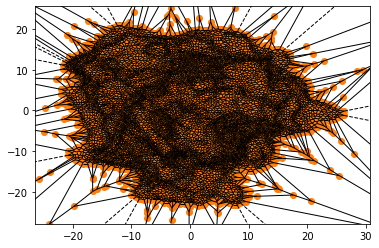

In [ ]:
import numpy as np
from stl import mesh
from scipy.spatial import Voronoi, voronoi_plot_2d


# Load the STL file and parse it into a mesh object
stl_file = '5nlt_surface.stl'
your_mesh = mesh.Mesh.from_file(stl_file)

# Extract the vertices of the mesh as a 2D array
vertices = your_mesh.vectors.reshape((-1, 3))

# Perform the Voronoi tessellation on the vertices
vor = Voronoi(vertices[:,:2])

# Plot the Voronoi diagram
voronoi_plot_2d(vor)

# Save the plot to an image file
plt.savefig('5nlt_surface.png')


In [1]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.6/678.6 KB 35.9 MB/s eta 0:00:00


In [14]:
# convexity and concavity


import trimesh

# Load the STL file into a Trimesh object
stl_file = '/content/drive/MyDrive/ML/existing_struc/structures/AA9_stl/6ydc.stl'
mesh = trimesh.load(stl_file)

# Calculate the convex hull of the mesh
convex_hull = mesh.convex_hull

# Calculate the volume of the mesh and the convex hull
mesh_volume = mesh.volume
convex_hull_volume = convex_hull.volume
surface = mesh.scale
# Calculate the concavity and convexity of the mesh
concavity = 1 - (mesh_volume / convex_hull_volume)
convexity = 1 - concavity
area = mesh.area

# Calculate the compactness of the mesh
compactness = (36 * 3.14159 * mesh_volume**2)**(1/3) / total_area


# Calculate the radius of a sphere with the same volume as the mesh
radius = (3 *  mesh_volume / (4 * 3.14159))**(1/3)

# Calculate the surface area of a sphere with the same volume as the mesh
sphere_surface_area = 4 * 3.14159 * radius**2



print("scale:",surface)
print("area:",area)
print('mesh_volume: {:.2f}'.format(mesh_volume))
print('convex_volume: {:.2f}'.format(convex_hull_volume))
print('Concavity: {:.2f}%'.format(concavity * 100))
print('Convexity: {:.2f}%'.format(convexity * 100))
print('compactness:',compactness)
# print('Sphericity: {:.2f}'.format(sphericity))

# print('Concave area: {:.2f}'.format(concave_area))
# print('Convex area: {:.2f}'.format(convex_area))


scale: 85.21526840729967
area: 8524.61346101551
mesh_volume: 27423.39
convex_volume: 47111.94
Concavity: 41.79%
Convexity: 58.21%
compactness: 0.5158895823543497


In [ ]:
import open3d as o3d
import numpy as np

# Load the STL file into a mesh object
stl_file = '5nlt_cartoon.stl'
mesh = o3d.io.read_triangle_mesh(stl_file)

# Calculate the radius of the minimum bounding sphere of the mesh
diameter = np.linalg.norm(mesh.get_max_bound() - mesh.get_min_bound())
radius = diameter / 2

# Calculate the moment of inertia of the mesh
points = np.asarray(mesh.vertices)
center_of_mass = np.mean(points, axis=0)
points -= center_of_mass
inertia_tensor = np.zeros((3, 3))
for i in range(len(points)):
    inertia_tensor += np.outer(points[i], points[i])
eigvals, _ = np.linalg.eig(inertia_tensor)

# Calculate the asphericity of the mesh
asphericity = max(eigvals) / radius**2 - 1

print('Asphericity: {:.2f}'.format(asphericity))


Asphericity: 5918.66


<trimesh.primitives.Sphere>

In [ ]:
!pip install pyvista

In [ ]:
import pyvista as pv

# Load the STL file into a PyVista mesh object
stl_file = '5nlt_surface.stl'
mesh = pv.read(stl_file)

# Calculate the convex hull of the mesh
convex_hull = mesh.GetBounds()

# Calculate the volume of the mesh and the convex hull
mesh_volume = mesh.volume
# convex_hull_volume = convex_hull.volume

# # Calculate the concavity and convexity of the mesh
# concavity = 1 - (mesh_volume / convex_hull_volume)
# convexity = 1 - concavity

# # Calculate the concave and convex areas of the mesh
# surface_areas = mesh.compute_cell_sizes(surface_area=True)
# concave_surfaces = surface_areas[surface_areas < 0]
# convex_surfaces = surface_areas[surface_areas > 0]
# concave_area = abs(concave_surfaces.sum())
# convex_area = convex_surfaces.sum()

print(convex_hull)
print('Concavity: {:.2f}%'.format(concavity * 100))
print('Convexity: {:.2f}%'.format(convexity * 100))
print('Concave area: {:.2f}'.format(concave_area))
print('Convex area: {:.2f}'.format(convex_area))



(-21.672000885009766, 25.952999114990234, -23.441999435424805, 21.155000686645508, -30.726999282836914, 23.500999450683594)
Concavity: 40.54%
Convexity: 59.46%
Concave area: 0.00
Convex area: 0.00


In [ ]:
import vtk

# Load the STL file into a vtkPolyData object
stl_file = '5nlt_surface.stl'
reader = vtk.vtkSTLReader()
reader.SetFileName(stl_file)
reader.Update()
mesh = reader.GetOutput()

# Calculate the convex hull of the mesh
convex_hull_filter = vtk.vtkDelaunay3D()
convex_hull_filter.SetInputData(mesh)
convex_hull_filter.Update()
convex_hull = convex_hull_filter.GetOutput()

# Calculate the volume of the mesh and the convex hull
mesh_mass_properties = vtk.vtkMassProperties()
mesh_mass_properties.SetInputData(mesh)
mesh_volume = mesh_mass_properties.GetVolume()
convex_hull_mass_properties = vtk.vtkMassProperties()
convex_hull_mass_properties.SetInputData(convex_hull)
convex_hull_volume = convex_hull_mass_properties.GetVolume()

# Calculate the concavity and convexity of the mesh
concavity = 1 - (mesh_volume / convex_hull_volume)
convexity = 1 - concavity

# Calculate the concave and convex areas of the mesh
surface_areas = vtk.vtkTriangleFilter()
surface_areas.SetInputData(mesh)
surface_areas.Update()
surface_area_array = surface_areas.GetOutput().GetCellData().GetArray('Area')
concave_surfaces = [surface_area_array.GetTuple(i)[0] for i in range(mesh.GetNumberOfCells()) if surface_area_array.GetTuple(i)[0] < 0]
convex_surfaces = [surface_area_array.GetTuple(i)[0] for i in range(mesh.GetNumberOfCells()) if surface_area_array.GetTuple(i)[0] > 0]


ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkMassProperties (0x4507910) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


ZeroDivisionError: ignored

In [ ]:
mesh_volume

27541.166170442106

In [ ]:
sum

-10778.16617044212

In [ ]:
import open3d as o3d
import numpy as np

# Load the STL file into a mesh object
stl_file = '5nlt_surface.stl'
mesh = o3d.io.read_triangle_mesh(stl_file)

# Compute vertex normals and curvature
mesh.compute_vertex_normals()
mesh.compute_vertex_curvature()

# Get the curvature values for each vertex
curvature_values = np.asarray(mesh.vertex_curvature)

# Calculate the standard deviation of the curvature values
curvature_std = np.std(curvature_values)

# Calculate the percentage of vertices with negative curvature
negative_curvature = np.count_nonzero(curvature_values < 0) / len(curvature_values) * 100

print('Roughness: {:.2f}'.format(curvature_std))
print('Smoothness: {:.2f}'.format(100 - negative_curvature))


AttributeError: ignored

In [ ]:
import trimesh

# Load the STL file into a mesh object
stl_file = '5nlt_surface.stl'
mesh = trimesh.load(stl_file)

# Compute mean curvature values for each vertex
curvature_values = mesh.vertex_attributes

# Calculate the standard deviation of the curvature values
curvature_std = curvature_values.std()

# Calculate the percentage of vertices with negative curvature
negative_curvature = (curvature_values < 0).sum() / len(curvature_values) * 100

# Compute the surface area variation as the standard deviation of triangle areas
triangle_areas = mesh.area_faces
area_variation = triangle_areas.std()

print('Roughness: {:.2f}'.format(curvature_std))
print('Smoothness: {:.2f}'.format(100 - negative_curvature))
print('Surface Area Variation: {:.2f}'.format(area_variation))


AttributeError: ignored

In [ ]:
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from scipy.spatial import Delaunay
import trimesh

# Load the STL file into a mesh object
stl_file = '5nlt_sticks.stl'
mesh = trimesh.load(stl_file)

# Compute the Delaunay triangulation of the mesh vertices
tri = Delaunay(mesh.vertices)

# Compute the signed distances from each triangle to the surface
distances = trimesh.proximity.signed_distance(mesh, tri.points)

# Compute the standard deviation of the signed distances as a measure of roughness
roughness = np.std(distances)

# Compute the percentage of triangles with negative signed distances as a measure of smoothness
smoothness = np.sum(distances < 0) / len(distances) * 100

print('Roughness: {:.2f}'.format(roughness))
print('Smoothness: {:.2f}'.format(smoothness))

Roughness: 0.00
Smoothness: 0.00
